# Ocean convection example

In this example, two-dimensional convection into a stratified fluid
mixes a phytoplankton-like tracer. This example demonstrates how

  * to set boundary conditions;
  * to defined and insert a user-defined forcing function into a simulation;
  * to use the `TimeStepWizard` to manage and adapt the simulation time-step.

To begin, we load Oceananigans, a plotting package, and a few miscellaneous useful packages.

In [3]:
using Oceananigans, PyPlot, Random, Printf

## Parameters

We choose a modest two-dimensional resolution of 128² in a 64² m² domain ,
implying a resolution of 0.5 m. Our fluid is initially stratified with
a squared buoyancy frequency

$$ N^2 = 10^{-5} \, \mathrm{s^{-2}} $$

and a surface buoyancy flux

$$ Q_b = 10^{-8} \, \mathrm{m^3 \, s^{-2}} $$

Because we use the physics-based convection whereby buoyancy flux by a
positive vertical velocity implies positive flux, a positive buoyancy flux
at the top of the domain carries buoyancy out of the fluid and causes convection.
Finally, we end the simulation after 1 day.

In [4]:
Nz = 128
Lz = 64.0
N² = 1e-5
Qb = 1e-8
end_time = 1day

86400.0

## Creating boundary conditions

Create boundary conditions. Note that temperature is buoyancy in our problem.

In [5]:
buoyancy_bcs = HorizontallyPeriodicBCs(   top = BoundaryCondition(Flux, Qb),
                                       bottom = BoundaryCondition(Gradient, N²))

(x = CoordinateBoundaryConditions{BoundaryCondition{Periodic,Nothing},BoundaryCondition{Periodic,Nothing}}(BoundaryCondition{Periodic,Nothing}(nothing), BoundaryCondition{Periodic,Nothing}(nothing)), y = CoordinateBoundaryConditions{BoundaryCondition{Periodic,Nothing},BoundaryCondition{Periodic,Nothing}}(BoundaryCondition{Periodic,Nothing}(nothing), BoundaryCondition{Periodic,Nothing}(nothing)), z = CoordinateBoundaryConditions{BoundaryCondition{Flux,Float64},BoundaryCondition{Gradient,Float64}}(BoundaryCondition{Flux,Float64}(1.0e-8), BoundaryCondition{Gradient,Float64}(1.0e-5)))

## Define a forcing function

Our forcing function roughly corresponds to the growth of phytoplankton in light
(with a penetration depth of 16 meters here), and death due to natural mortality
at a rate of 1 phytoplankton unit per second.

In [13]:
growth_and_decay(x, y, z, t) = exp(z/16) - 1

# Wrap the `growth_and_decay` function in a `SimpleForcing` object to compute its values at 
# the correct location on the staggered grid
plankton_forcing = SimpleForcing(growth_and_decay)

SimpleForcing{Oceananigans.Cell,Oceananigans.Cell,Oceananigans.Cell,typeof(growth_and_decay),Nothing}(growth_and_decay, nothing)

## Instantiate the model

Note that the plankton forcing is passed as a keyword argument to `ModelForcing`, and the buoyancy boundary conditions
are passed as an argument to `BoundaryConditions`.

In [14]:
model = Model(
                   grid = RegularCartesianGrid(N = (Nz, 1, Nz), L = (Lz, Lz, Lz)),
                closure = ConstantIsotropicDiffusivity(ν=1e-4, κ=1e-4),
               coriolis = FPlane(f=1e-4),
                tracers = (:b, :plankton),
               buoyancy = BuoyancyTracer(),
                forcing = ModelForcing(plankton=plankton_forcing),
    boundary_conditions = BoundaryConditions(b=buoyancy_bcs)
);

## Set initial condition

In [15]:
Ξ(z) = randn() * z / Lz * (1 + z / Lz) # noise
b₀(x, y, z) = N² * z + N² * Lz * 1e-6 * Ξ(z)
set!(model, b=b₀)

## The `TimeStepWizard`

The `TimeStepWizard` manages time step size for adaptive time-stepping based on the advective and 
diffusive CFL criterion. Here we create a wizard that will keep the time-step small enough such that 
The CFL number is no larger than 0.2, or

$$ CFL = \max \left ( \frac{\max(|u|) \Delta t}{\Delta x}, \frac{\max(|v|) \Delta t}{\Delta y}, \frac{\max(|w|) \Delta t}{\Delta z} \right ) < 0.2 $$

We also specify an initial time-step `Δt=1.0`, a maximum time-step `max_Δt=1.0`, and ask that the time-step change by no more than 10% on each update. The time-step is updated by calling `update_Δt!(wizard, model)` and accessed via `wizard.Δt`.

In [16]:
# A wizard for managing the simulation time-step.
wizard = TimeStepWizard(cfl=0.2, Δt=1.0, max_change=1.1, max_Δt=90.0)

TimeStepWizard{Float64}(0.2, 0.02, 1.1, 0.5, 90.0, 1.0)

## Run the simulation

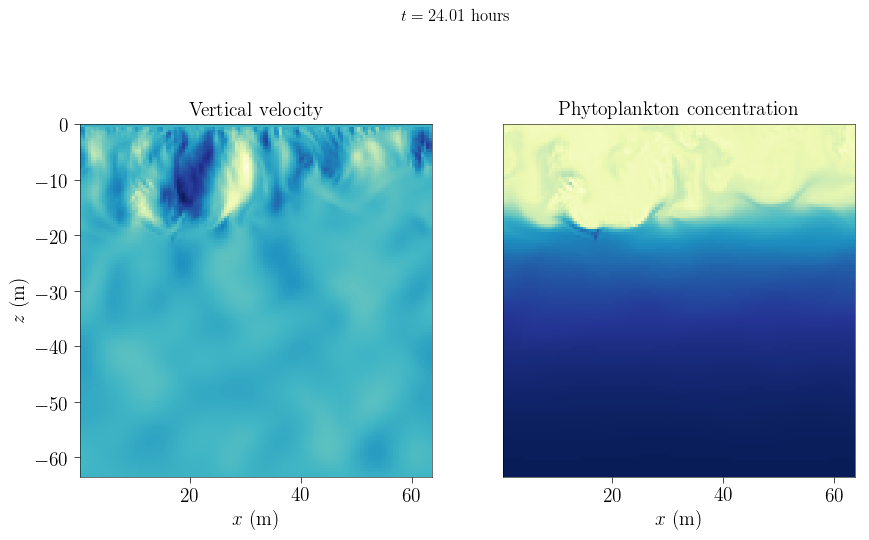

In [17]:
# Create a plot
fig, axs = subplots(ncols=2, figsize=(10, 6))

xC = repeat(model.grid.xC, 1, model.grid.Nz)
zF = repeat(reshape(model.grid.zF[1:end-1], 1, model.grid.Nz), model.grid.Nx, 1)
zC = repeat(reshape(model.grid.zC, 1, model.grid.Nz), model.grid.Nx, 1)

# Run the model
while model.clock.time < end_time
    update_Δt!(wizard, model)
    walltime = @elapsed time_step!(model, 10, wizard.Δt)

    sca(axs[1]); cla()
    pcolormesh(xC, zF, model.velocities.w[:, 1, :])
    title("Vertical velocity")
    xlabel("\$ x \$ (m)")
    ylabel("\$ z \$ (m)")

    sca(axs[2]); cla()
    pcolormesh(xC, zC, model.tracers.plankton[:, 1, :])
    title("Phytoplankton concentration")
    xlabel("\$ x \$ (m)")
    axs[2].tick_params(left=false, labelleft=false)

    suptitle(@sprintf("\$ t = %.2f\$ hours", model.clock.time / hour))
    [ax.set_aspect(1) for ax in axs]
    gcf(); pause(0.01)
end

display()

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*